In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)



In [2]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [3]:
df = pd.read_csv("../k2scoc/results/tables/full_table.csv")


hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
teffrange = (df.Teff_median<=6000) & (df.Teff_median>=2500)
df = df[(hasflares  | wassearched) & teffrange]
df.shape

(5605, 24)

In [4]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")
labels = ["2500-3000","3000-3250","3250-3500",
          "3500-3750","3750-4000","4000-5000",
          "5000-6000"]
Mmid  = [0.097, .19, .36, .47, .55, .71, .94]
masses = pd.DataFrame({"Teff_median" : labels,
                       "M_Msun" : Mmid})

params = pd.read_csv("cluster_parameters_merged.csv")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T = T.merge(masses, how="left", on="Teff_median")
T = T.merge(params[["cluster","age (Myr)"]], how="left", on="cluster")
assert T.LC_time_years.sum() - tobs < 1e-10
T.shape

Total observing time: 384.36 years!


(35, 5)

In [5]:
def gyroflaremodel(t, m):
    a1, a2, a3 = -.07, .79, -1.06
    b1, b2, b3 = 2.01, -25.15, 33.99
    alpha = a1 * np.log10(t) + a2 * m + a3
    beta = b1 * np.log10(t) + b2 * m + b3
    return np.array([alpha, beta, t, m])

#T[["alpha","beta"]] = 
s = T.apply(lambda x: gyroflaremodel(x["age (Myr)"], x["M_Msun"]), axis=1)
s = pd.DataFrame(s.tolist(), columns=['alpha', 'beta', "age (Myr)", "M_Msun"])
T = T.merge(s, how="left", on=[ "age (Myr)", "M_Msun"])
T.shape

(35, 7)

In [8]:
gyroflaremodel(135, 0.5)

array([ -0.81412336,  25.69697087, 135.        ,   0.5       ])

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Fitted power law alpha=1.851632802928993
Fitted power law beta=1.7532294166268853e+28


Text(0, 0.5, 'cumulative number of flares per year')

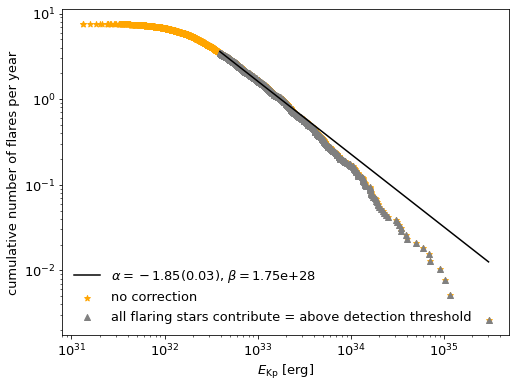

In [89]:
fig, ax =  plt.subplots(1, figsize=(8,6))
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*", label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

alpha_en, alpha_en_err = ffd.fit_powerlaw()
print(f"Fitted power law alpha={ffd.alpha}")

#ffd.alpha, ffd.alpha_err = 2., .2

betas, beta, beta_err = ffd.fit_beta_to_powerlaw(mode="energy")
print(f"Fitted power law beta={ffd.beta}")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()


ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey", label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", label=fr"$\alpha=-${ffd.alpha:.2f}({ffd.alpha_err:.2f}), $\beta=${ffd.beta:.2e}")


# resfullsample["alpha_en"] = alpha_en
# resfullsample["alpha_en_err"] = alpha_en_err
# resfullsample["beta_en"] = beta
# resfullsample["beta_en_err"] = beta_err
# resfullsample["nflares_en_tot"] = len(ed)
# resfullsample["nflares_en_for_fit"] = len(ffd.ed)
# resfullsample["ispowerlaw_en"] = ispowerlaw
# resfullsample["istruncated_en"] = truncated

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"$E_\mathrm{Kp}$ [erg]")
plt.ylabel("cumulative number of flares per year")

#plt.savefig(f"plots/{tstamp}_full_sample_ffd_energy.png", dpi=300)

## Teff bins


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(2913, 25)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a cop

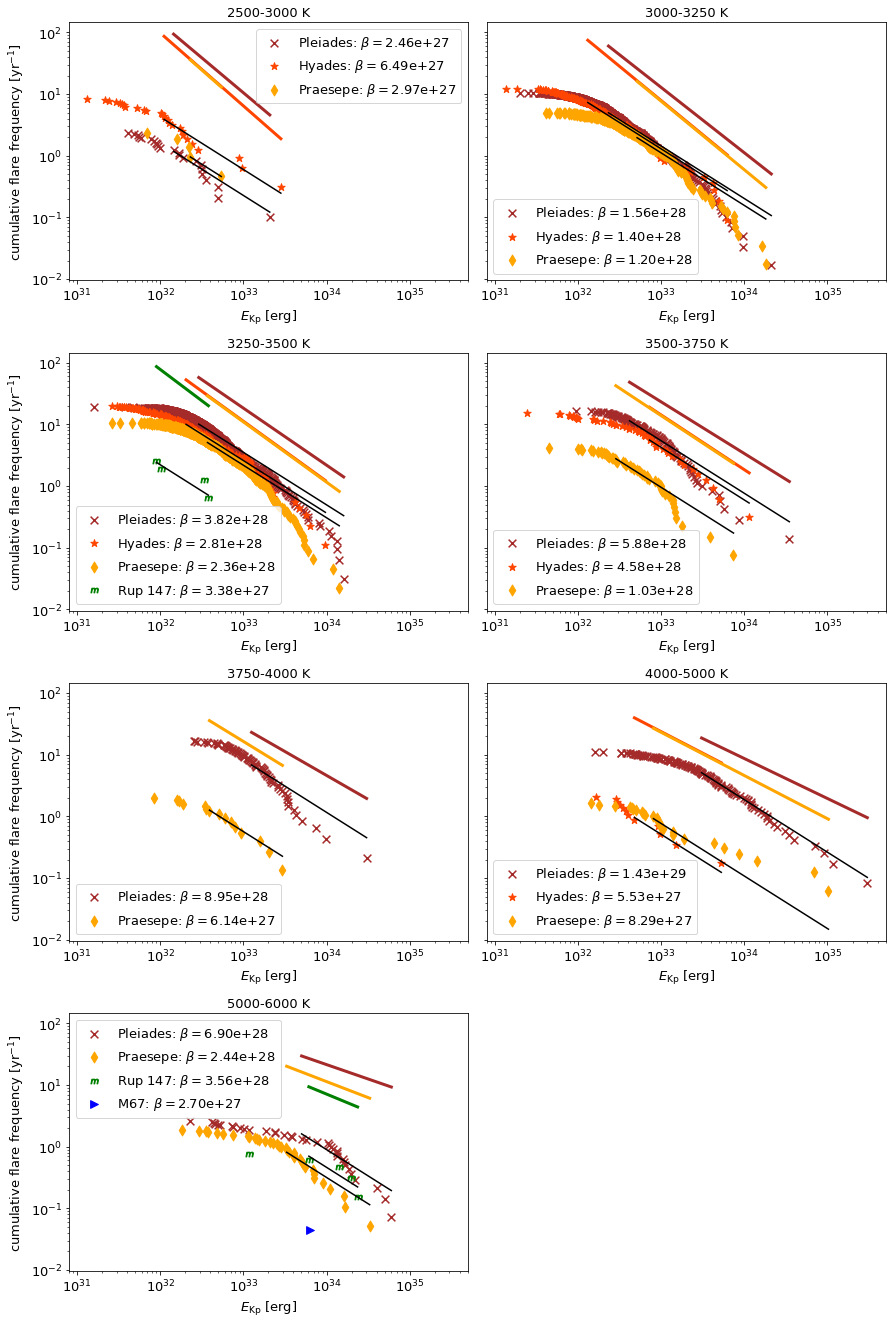

In [92]:
resen ={}
bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
df2 = df2[hasflares]
bins_T = pd.cut(df2["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
print(df2.shape)
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5),sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):

      #  print(i,j)
      #  print(h.shape)
        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha, ffd.alpha_err = alpha_en, alpha_en_err

            betas, beta, beta_err = ffd.fit_beta_to_powerlaw(mode="energy")
            #print(f"Fitted power law beta={ffd.beta}")
            
            if j == "ngc2682":
                E, y = ffd.ed[0], ffd.freq[0]
                ffd.beta = y * np.power(E, ffd.alpha-1)
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
                
            else:
                a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * 365.25 * (-ab.alpha.iloc[0])
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3)#, label=f"{A}, {B}")
            resen[i][ccol[j][0]]={"beta_en":ffd.beta,
                                "beta_en_err":ffd.beta_err,
                                "nflares_en":len(ed),
                                "age":ccol[j][3],
                                "age_uperr":ccol[j][4],
                                "age_lowerr":ccol[j][5],
                                "ispowerlaw_en":ffd.is_powerlaw(),
                                "istruncated_en": ffd.is_powerlaw_truncated()
                                }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\beta=${ffd.beta:.2e}")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].legend()
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
#plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy.png", dpi=300)

In [ ]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta.sort_values(by="nflares")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


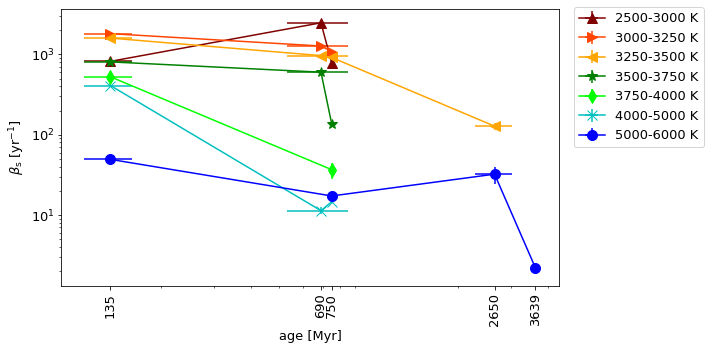

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
           label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
          marker=Tcols[str(label)][0],markersize=10)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta_\mathrm{s}$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED.png", dpi=300)

In [15]:
beta_s = betaen_.merge(betaed_, left_index=True,right_index=True)
for b in ["beta","beta_err","beta_en","beta_en_err"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)


for out, beta, beta_err in [(r"$\beta_\mathrm{s}$","beta","beta_err"),
                            (r"$\beta_\mathrm{erg}$","beta_en","beta_en_err")
                            ]:
    beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_err]))+1).astype(int)
    beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
    beta_s["berr"] = (np.rint(np.log10(beta_s[beta_err]))).astype(int)
    beta_s["B"] = beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
    beta_s["Berr"] = beta_s.apply(lambda x: np.round(x[beta_err]/10**x.b, x.perr), axis=1)        
    beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left({x.Berr}\right)\cdot 10^{x.b}$", axis=1)

    beta_s[out] = beta_s[out].apply(lambda x: "$" + x.replace("^","^{").replace("_","}_{").replace("$","}")[1:] + "$")

    
rename = {"nflares":r"$n_\mathrm{s}$",
         "nflares_en":r"$n_\mathrm{erg}$",
          "istruncated":r"$tr_\mathrm{s}$",
         "istruncated_en":r"$tr_\mathrm{erg}$",
         "ispowerlaw":r"$pl_\mathrm{s}$",
         "ispowerlaw_en":r"$pl_\mathrm{erg}$",}
beta_s = beta_s[[r"$\beta_\mathrm{s}$","nflares","istruncated","ispowerlaw",
      r"$\beta_\mathrm{erg}$","nflares_en","istruncated_en","ispowerlaw_en",]].rename(index=str, columns=rename)
beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
with open(f"/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/tables/powerlaw_SpT.tex", "w") as f:
    f.write(stri)

In [16]:
print(stri)

\begin{tabular}{lccccccccr}
\hline
          &         &                     $\beta_\mathrm{s}$ & $n_\mathrm{s}$ & $tr_\mathrm{s}$ & $pl_\mathrm{s}$ &                        $\beta_\mathrm{erg}$ & $n_\mathrm{erg}$ & $tr_\mathrm{erg}$ & $pl_\mathrm{erg}$ \\
\hline
2500-3000 & Hyades &     $2.48\left(0.1\right)\cdot 10^{3}$ &             27 &           False &            True &        $0.65\left(0.02\right)\cdot 10^{28}$ &               27 &             False &              True \\
          & Pleiades &    $0.82\left(0.03\right)\cdot 10^{3}$ &             23 &           False &            True &        $2.46\left(0.09\right)\cdot 10^{27}$ &               23 &             False &              True \\
          & Praesepe &  $0.777\left(0.024\right)\cdot 10^{3}$ &              5 &           False &            True &      $2.968\left(0.093\right)\cdot 10^{27}$ &                5 &             False &              True \\
3000-3250 & Hyades &    $1.27\left(0.04\right)\cdot 10^{3}$ &        

# Notes on very old clusters

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [17]:

df[(df.cluster=="ngc6774") & (df.Teff_median > 3000.)].dropna(subset=["real"])[["dtp_tot", "EPIC","C","Teff_median", "ed_rec","note", "todrop"]]

,dtp_tot,EPIC,C,Teff_median,ed_rec,note,todrop
58,3449.0,219604743,7,3319.426162,3850.128408,SSO,NaN
59,3449.0,219619241,7,3578.654977,1194.922862,SSO,NaN
457,3449.0,219591752,7,3314.972737,246.570324,NaN,NaN
571,3449.0,219656722,7,3336.239940,402.529765,NaN,NaN
572,3449.0,219656722,7,3336.239940,332.306827,NaN,NaN
...,...,...,...,...,...,...,...
6047,3449.0,219280168,7,5015.000000,NaN,NaN,NaN
6048,3449.0,219037489,7,5032.250000,NaN,NaN,NaN
6049,3449.0,219556441,7,3334.844273,NaN,NaN,NaN
6050,3449.0,219439085,7,3698.240657,NaN,NaN,NaN


In [18]:
3449/2/24

71.85416666666667

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [32]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

2822    5188.269447
Name: Teff_median, dtype: float64

# Compare Shibayama 2013 Kepler superflares to our flares

In [29]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

141.82081199599583

In [6]:
1/800, 1/5000

(0.00125, 0.0002)

In [22]:
800/18, 5000/128

(44.44444444444444, 39.0625)

In [15]:
np.power(1e34,-1.85) * 2.05e27 / .85

3.0362318755035595e-36

In [ ]:
18-130 